<a href="https://colab.research.google.com/github/pranavsouri/LSTM/blob/main/Anomaly_Detection_Time_Series_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Anomaly Detection in Time Series with Keras


## Task 1: Import Libraries

In [785]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

x_axis = 'TEST_PERIOD_FORMATTED'
y_axis = 'ATT_TP_DL_MV'
percent = 0.9
validation_percent = 0.1
file_name = 'amChartsDip 90-10.csv'

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.2


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [786]:
data = pd.read_csv(file_name)
df = pd.DataFrame()
df[x_axis] = pd.to_datetime(data[x_axis])
df[y_axis] = data[y_axis]
df = df.dropna()

df.head()

,TEST_PERIOD_FORMATTED,ATT_TP_DL_MV
0,2019-07-02,38.88
1,2019-07-03,38.61
2,2019-07-04,38.41
3,2019-07-05,36.79
4,2019-07-06,38.89


In [787]:
df.shape

(606, 2)

In [788]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.TEST_PERIOD_FORMATTED, y=df.ATT_TP_DL_MV,
                    mode='lines',
                    name=y_axis))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [789]:
train_size = int(len(df) * percent)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(545, 2) (61, 2)


In [790]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[[y_axis]])

train[y_axis] = scaler.transform(train[[y_axis]])
test[y_axis] = scaler.transform(test[[y_axis]])

## Task 4: Create Training and Test Splits

In [791]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [792]:
time_steps = 30

x_train, y_train = create_dataset(train[[y_axis]], train.ATT_TP_DL_MV, time_steps)
x_test, y_test = create_dataset(test[[y_axis]], test.ATT_TP_DL_MV, time_steps)

print(x_train.shape)

(515, 30, 1)


## Task 5: Build an LSTM Autoencoder

In [793]:
timesteps = x_train.shape[1]
num_features = x_train.shape[2]

In [794]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_70 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_35 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 lstm_71 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_71 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_35 (TimeDi  (None, 30, 1)            129       
 stributed)                                          

## Task 6: Train the Autoencoder

In [795]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=validation_percent,
    callbacks=[es],
    shuffle=False
)

Epoch 1/100
15/15 [==============================] - 4s 60ms/step - loss: 0.3737 - val_loss: 0.6535
Epoch 2/100
15/15 [==============================] - 0s 11ms/step - loss: 0.2658 - val_loss: 0.5594
Epoch 3/100
15/15 [==============================] - 0s 10ms/step - loss: 0.2190 - val_loss: 0.4249
Epoch 4/100
15/15 [==============================] - 0s 10ms/step - loss: 0.2159 - val_loss: 0.3322
Epoch 5/100
15/15 [==============================] - 0s 11ms/step - loss: 0.3180 - val_loss: 0.4117
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 0.2705 - val_loss: 1.3809
Epoch 7/100
15/15 [==============================] - 0s 10ms/step - loss: 0.2145 - val_loss: 0.3496
Epoch 8/100
15/15 [==============================] - 0s 10ms/step - loss: 0.1853 - val_loss: 0.2505
Epoch 9/100
15/15 [==============================] - 0s 10ms/step - loss: 0.2381 - val_loss: 0.2764
Epoch 10/100
15/15 [==============================] - 0s 10ms/step - loss: 0.2506 - val_loss: 1.2157

## Task 7: Plot Metrics and Evaluate the Model

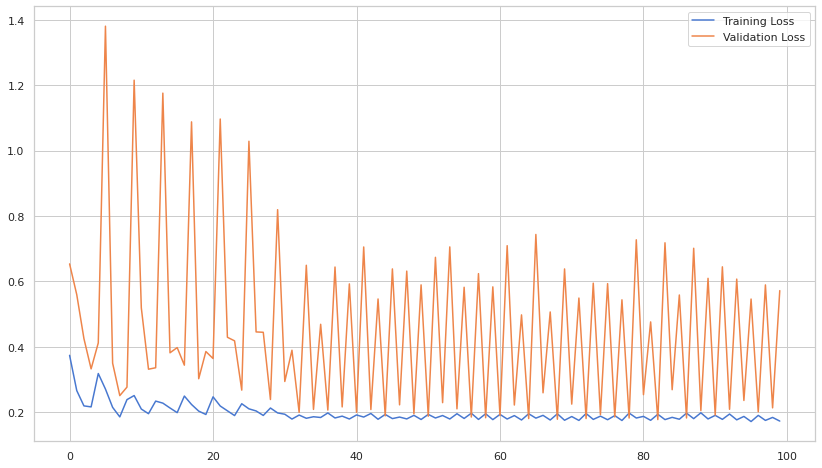

In [796]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [797]:
x_train_pred = model.predict(x_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(x_train_pred - x_train), axis=1), columns=['Error'])

In [798]:
train_mae_loss

,Error
0,0.425277
1,0.429711
2,0.422603
3,0.420903
4,0.418809
...,...
510,0.556998
511,0.568876
512,0.571841
513,0.570127


In [799]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 22ms/step - loss: 0.9789


0.9789032340049744

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



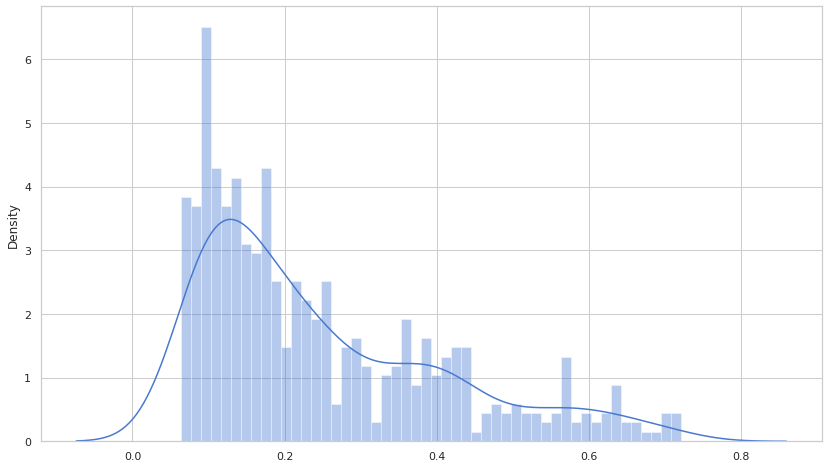

In [800]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [801]:
x_test_pred = model.predict(x_test)

test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



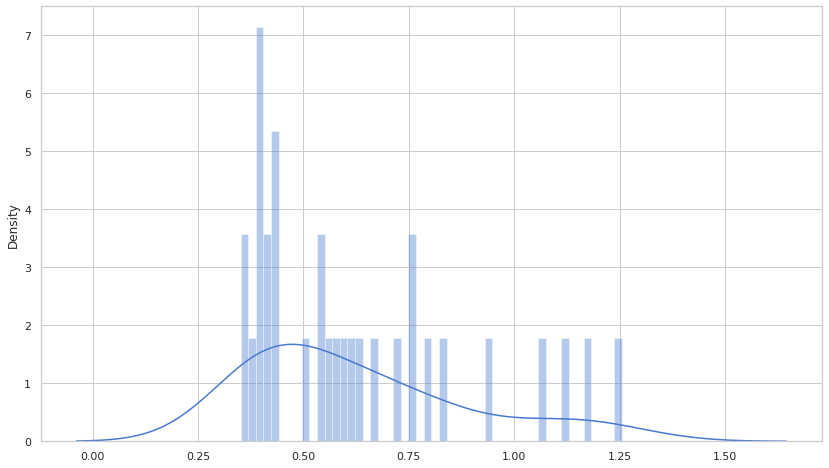

In [802]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [803]:
THRESHOLD = float(np.percentile(train_mae_loss, 85))

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df[y_axis] = test[time_steps:].ATT_TP_DL_MV

In [804]:
THRESHOLD

0.425594455169634

In [805]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].TEST_PERIOD_FORMATTED, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].TEST_PERIOD_FORMATTED, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [806]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,TEST_PERIOD_FORMATTED,ATT_TP_DL_MV,loss,threshold,anomaly
592,2021-02-13,1.960650,0.436495,0.425594,True
593,2021-02-14,2.017186,0.429080,0.425594,True
595,2021-02-16,-0.555871,0.766397,0.425594,True
596,2021-02-17,-0.010604,1.126982,0.425594,True
597,2021-02-18,0.935447,1.255713,0.425594,True


In [807]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].TEST_PERIOD_FORMATTED, y=test[time_steps:].ATT_TP_DL_MV,
                    mode='lines',
                    name=y_axis))
fig.add_trace(go.Scatter(x=anomalies.TEST_PERIOD_FORMATTED, y=anomalies.ATT_TP_DL_MV,
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()